In [1]:
import pickle
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from time import time
from keras.applications.inception_v3 import InceptionV3
import keras.utils as image
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
import tensorflow as tf

C:\Users\EXTREME_RED\AppData\Local\Temp\ipykernel_17440\3597181659.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


In [4]:
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
#filename='D:\\Paper\\Mimic Human Level Intelligence in Image Descriptioning\\train_split.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [5]:
images = 'Flicker8k_Dataset/'

# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [42]:
train_images_file = 'Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [43]:
# Below file conatains the names of images to be used in test data
test_images_file = 'Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [6]:
def preprocess(image_path):
    
    img = image.load_img(image_path, target_size=(224, 224))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [7]:
model=VGG19()
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [8]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (4096, )
    return fea_vec

In [47]:
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

1/1 [==============================] - 0s 17ms/step
Time taken in seconds = 353.311625957489


In [48]:
import pickle
with open("encoded_trainInception_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [49]:
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

1/1 [==============================] - 0s 19ms/step
Time taken in seconds = 62.486074924468994


In [50]:
with open("encoded_testInception_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [9]:
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions2.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [10]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [11]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [12]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [13]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [14]:
# Load Glove vectors
glove_dir = 'archive'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [15]:
embedding_dim = 200
vocab_size = len(ixtoword)+1
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [17]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
#from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [18]:
from numpy import array
def data_generator2(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [19]:
import pickle
train_features = pickle.load(open("encoded_trainInception_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [96]:
# LSTM Model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [25]:
# Replace LSTM with BiLSTM
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)

se3 = Bidirectional(LSTM(128))(se2)

fe2_dense = Dense(256, activation='relu')(fe2)

decoder1 = add([fe2_dense, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model2 = Model(inputs=[inputs1, inputs2], outputs=outputs)


In [26]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 dropout_2 (Dropout)         (None, 4096)                 0         ['input_4[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 34, 200)              330400    ['input_5[0][0]']             
                                                                                            

In [114]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)





Physical devices cannot be modified after being initialized


In [27]:
ess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping: no known devices.


In [35]:

path_checkpoint = "BiLstmcp.ckpt"
directory_checkpoint = os.path.dirname(path_checkpoint)

callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint, save_weights_only=True, verbose=1)

In [29]:
# Bidirectional LSTM Model
model2.layers[3].set_weights([embedding_matrix])
model2.layers[3].trainable = False
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 50
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

for i in range(epochs):
    generator = data_generator2(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model2.fit(generator, epochs=1, steps_per_epoch=steps,callbacks=[callback], verbose=1)

model2.save('BiLSTM_checkpoint1.h5')
    

2000/2000 [==============================] - ETA: 0s - loss: 4.1872 - accuracy: 0.2321
Epoch 1: saving model to BiLstmcp.ckpt
2000/2000 [==============================] - ETA: 0s - loss: 3.4798 - accuracy: 0.2860
Epoch 1: saving model to BiLstmcp.ckpt
1999/2000 [============================>.] - ETA: 0s - loss: 3.2522 - accuracy: 0.3052
Epoch 1: saving model to BiLstmcp.ckpt
1999/2000 [============================>.] - ETA: 0s - loss: 3.1133 - accuracy: 0.3189
Epoch 1: saving model to BiLstmcp.ckpt
1999/2000 [============================>.] - ETA: 0s - loss: 3.0125 - accuracy: 0.3271
Epoch 1: saving model to BiLstmcp.ckpt
2000/2000 [==============================] - ETA: 0s - loss: 2.9357 - accuracy: 0.3348
Epoch 1: saving model to BiLstmcp.ckpt
1998/2000 [============================>.] - ETA: 0s - loss: 2.8787 - accuracy: 0.3407
Epoch 1: saving model to BiLstmcp.ckpt
2000/2000 [==============================] - ETA: 0s - loss: 2.8262 - accuracy: 0.3453
Epoch 1: saving model to BiLstm

c:\Users\EXTREME_RED\anaconda3\envs\Final_Project_V2\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
model2.optimizer.lr = 0.0001
epochs = 50
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

for i in range(epochs):
    generator = data_generator2(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model2.fit(generator, epochs=1, steps_per_epoch=steps,callbacks=[callback], verbose=1)

model2.save('BiLSTM.h5')

1000/1000 [==============================] - 136s 136ms/step - loss: 2.1377 - accuracy: 0.4411


c:\Users\EXTREME_RED\anaconda3\envs\Final_Project_V2\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      330400      ['input_6[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_5[0][0]']                
                                                                                            

In [66]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [67]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [69]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [72]:
for i in range(epochs):
    generator = data_generator2(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

2000/2000 [==============================] - 110s 55ms/step - loss: 2.7955 - accuracy: 0.3484


In [73]:
for i in range(epochs):
    generator = data_generator2(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

2000/2000 [==============================] - 107s 53ms/step - loss: 2.6452 - accuracy: 0.3643


In [74]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [75]:
for i in range(epochs):
    generator = data_generator2(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

1000/1000 [==============================] - 47s 47ms/step - loss: 2.4748 - accuracy: 0.3913


In [76]:
model.save('First_try(1/4/24).h5')

In [37]:
with open("encoded_testInception_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [38]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model2.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [39]:
images = 'Flicker8k_Dataset/'

In [40]:
z=0

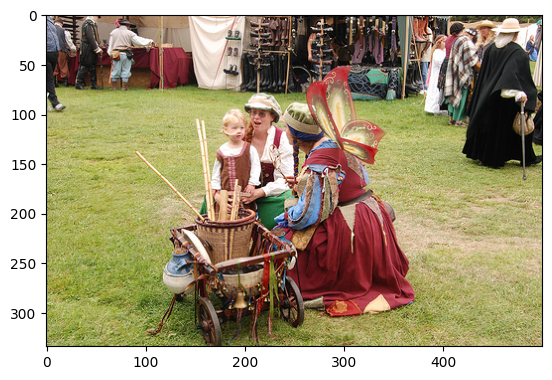

Greedy: group of people are playing in an outdoor attire attire


In [65]:
import matplotlib.pyplot as plt
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,4096))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

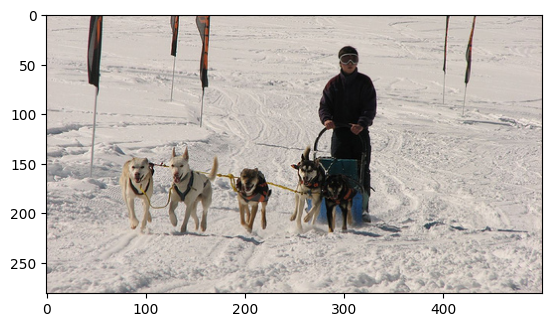

Greedy: two dogs are pulling sled through the snow


In [66]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,4096))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

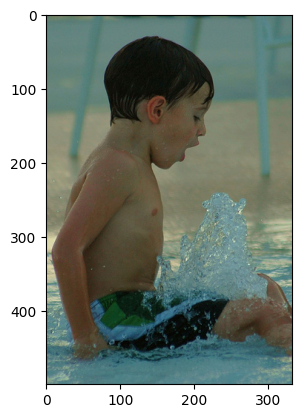

Greedy: boy in swimming pool


In [67]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,4096))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

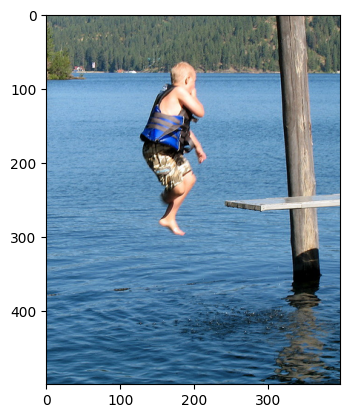

Greedy: man in swim trunks hits the dock


In [68]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,4096))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

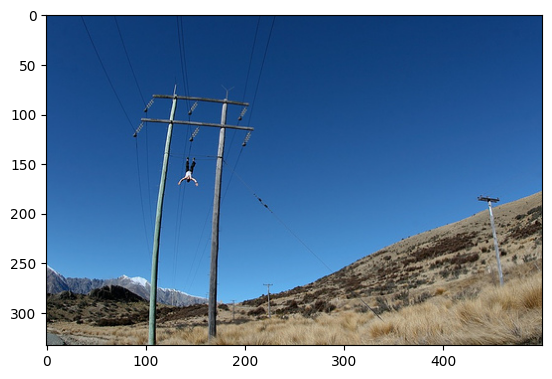

Greedy: man is standing on top of hill with his arms outstretched


In [69]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,4096))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))